<IPython.core.display.Javascript object>


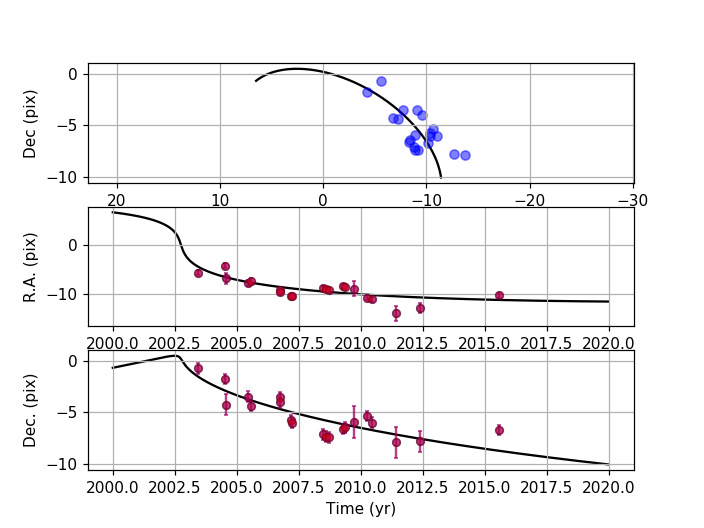

In [1]:
from __future__ import print_function, division
import numpy as np
from numpy import linalg as la
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from PyAstronomy import pyasl

'''
fits a keplerian orbit to the data
'''
#===========================================================


def generate_ellipse(num_pts, semi_major, eccentricity, inclination, periapsis, longitude, t_closest):
    """
    This function generates 'num_pts' number of points lying on a keplerian orbit starting from periapse defined by semi-major axis and eccentricity
    and finally rotated through the three euler angles
    """ 
    m = 4.3 #*10**6 solar mass
    n = np.sqrt(m*4.300952282/3.08567758**2/semi_major**3)*3.155692661 # mean motion: M=nt=sqrt(G(M+m)/a**3)t
    mu = m*4.300952282#mpc*(km/s)**2
    t = t_start - t_closest
    error = 10**(-5)
    flat_ellipse = np.zeros((num_pts, 4))
    flat_velocity = np.zeros((num_pts, 4))
    #------------------------------
    def eccentric_anomaly(eccentricity, m_anomaly, error):
        '''
        solving keoler's equation E(t)-e*sinE(t)=M(t). it is a transcendental equation and must be solved iteratively
        http://murison.alpheratz.net/dynamics/twobody/KeplerIterations_summary.pdf
        http://www.jgiesen.de/kepler/kepler.html
        '''
    # using astrolib package Instantiate the solver
        ks = pyasl.MarkleyKESolver()
    # Solves Kepler's Equation for a set of mean anomaly and eccentricity. Uses the algorithm presented by Markley 1995.
        E = ks.getE(m_anomaly, eccentricity)
        return E
    #------------------------------
    def position(semi_major, eccentricity, e_anomaly, t):
        z = 0.
        nu = 2*np.arctan2(np.sqrt(1+eccentricity)*np.sin(e_anomaly/2), np.sqrt(1-eccentricity)*np.cos(e_anomaly/2))
        y = semi_major*(1-eccentricity*np.cos(e_anomaly))*np.cos(nu)
        x = semi_major*(1-eccentricity*np.cos(e_anomaly))*np.sin(nu)
        r = np.column_stack((x, y, z, t))#mas
        return r
    #----------------------------------
    def velocity(mu, e_anomaly, semi_major, eccentricity, t):#(m/s)
        vy = -np.sin(e_anomaly)*np.sqrt(mu*semi_major)/semi_major/(1-eccentricity*np.cos(e_anomaly))
        vx = np.sqrt((1 - eccentricity**2)*mu*semi_major)*np.cos(e_anomaly)/semi_major/(1-eccentricity*np.cos(e_anomaly))
        vz = 0.
        v = np.column_stack((vx, vy, vz, t))
        return v
    #-----------------------------
    # Create an ellipse in the xy plane
    for i in range(num_pts):
        m_anomaly = n*t
        e_anomaly = eccentric_anomaly(eccentricity, m_anomaly, error)
        flat_ellipse[i] = position(semi_major, eccentricity, e_anomaly, t+t_closest)
        flat_velocity[i] = velocity(mu, e_anomaly, semi_major, eccentricity, t+t_closest)
        t += dt
    #----------------------------
    # Create a rotation matrix using Eulers angles
    rotation_matrix = np.array([[np.cos(-longitude)*np.cos(-inclination)*np.cos(-periapsis) - np.sin(-longitude)*np.sin(-periapsis), -np.cos(-periapsis)*np.sin(-longitude) - np.cos(-longitude)*np.cos(-inclination)*np.sin(-periapsis), np.cos(-longitude)*np.sin(-inclination)], [np.cos(-longitude)*np.sin(-periapsis) + np.cos(-inclination)*np.cos(-periapsis)*np.sin(-longitude), np.cos(-longitude)*np.cos(-periapsis) - np.cos(-inclination)*np.sin(-longitude)*np.sin(-periapsis), np.sin(-longitude)*np.sin(-inclination)], [-np.cos(-periapsis)*np.sin(-inclination), np.sin(-inclination)*np.sin(-periapsis), np.cos(-inclination)]])#ZYZ
    #-----------------------------
    # Rotate the ellipse
    rotated_ellipse = np.zeros((num_pts, 7))
    for i in range(num_pts):
        rotated_r = np.dot(rotation_matrix, flat_ellipse[i, 0:3])
        rotated_v = np.dot(rotation_matrix, flat_velocity[i, 0:3])
        rotated_ellipse[i] = np.column_stack((rotated_r[0], rotated_r[1], rotated_r[2], rotated_v[0], rotated_v[1], rotated_v[2], flat_ellipse[i, 3]))
    return rotated_ellipse
#=======================================================================================

def minimize():

    t, x, y, ex, ey = np.loadtxt(position_file, unpack=True)
    
    #converts offset to arcsec
    data = np.column_stack((t, x/1000, ex/1000, y/1000, ey/1000)) 
    
    tt = data[:, 0]
    xx = data[:, 1]
    ex = data[:, 2]
    yy = data[:, 3]
    ey = data[:, 4]

    def lnlike(params, tt, xx, ex, yy, ey):
        semi_major, eccentricity, inclination, periapsis, longitude, t_closest = params
        dummy_ellipse = generate_ellipse(num_pts, semi_major, eccentricity, inclination, periapsis, longitude, t_closest)#mpc
        residual = np.zeros(len(tt))
        for j in range(len(tt)):
            for i in range(num_pts):
                if abs(dummy_ellipse[i, 6] - tt[j]) < 0.001:
                    residual[j] = (xx[j]-dummy_ellipse[i, 0]/40)**2/(ex[j]**2) + (yy[j]-dummy_ellipse[i, 1]/40)**2/(ey[j]**2)#in arcsec
                    break
        lnlikelihood = np.sum(residual)#/(2*len(tt) - 6 - 1)
        print ('likelihood:', lnlikelihood)
        return lnlikelihood

    result = optimize.minimize(lnlike, initial_guess, args=(tt, xx, ex, yy, ey), method='L-BFGS-B', bounds=bnds, tol=1e-5) 
    semi_major, eccentricity, inclination, periapsis, longitude, t_closest = result["x"]

    print ('Minimized variables result:', semi_major,',', eccentricity,',', inclination,',', periapsis,',', longitude,',', t_closest)

    # This part is for the after-result plots
    dummy_ellipse = generate_ellipse(num_pts, semi_major, eccentricity, inclination, periapsis, longitude, t_closest)
    fig, ax = plt.subplots()
    ax.scatter(data[:, 1], data[:, 3], c = 'k', zorder = 0)
    ax.plot(dummy_ellipse[:, 0]/40, dummy_ellipse[:, 1]/40, '-', c = 'blue', markersize= 5, zorder = -1)
    ax.set_xlim(150, -150)
    ax.grid()
    plt.axis('equal')
    fig, ax = plt.subplots(2, 1)
    
    # dummy_ellipse[0][1] are RA, DEC offset from Sag A* respectively
    # for some reason, a factor of /40 must be added to convert them to arcsec
    ax[0].scatter(data[:, 0], data[:, 1], c = 'k', zorder = 0)
    ax[0].plot(dummy_ellipse[:, 6], dummy_ellipse[:, 0]/40, '-', c = 'blue', markersize= 5, zorder = -1)
    ax[0].grid()
    ax[1].scatter(data[:, 0], data[:, 3], c = 'k', zorder = 0)
    ax[1].plot(dummy_ellipse[:, 6], dummy_ellipse[:, 1]/40, '-', c = 'blue', markersize= 5, zorder = -1)
    ax[1].grid()

#------------------------------------------------------------
def plot():

    t, x, y, ex, ey = np.loadtxt(position_file, unpack=True)
    
    data = np.column_stack((t, x, ex, y, ey)) #in marcsec
    data2 = np.column_stack((t, x, ex, y, ey)) #in marcsec
    
    dummy_ellipse = generate_ellipse(num_pts, semi_major, eccentricity, inclination, periapsis, longitude, t_closest)
    
    # data & data2 are RA, DEC offset from Sag A* in marcsec
    # dummy_ellipse[0][1] are RA, DEC offset from Sag A* respectively
    #  1 arcsec = 40 mpc for Sag A* distance of 8000 pc from earth, a factor of /40 must be added to convert them to arcsec, here *1000 to marcsec
    
    fig, ax = plt.subplots(3, 1)
    ax[0].scatter(data2[:, 1]/13, data2[:, 3]/13, c = 'b', zorder = 0, alpha = 0.5)
    ax[0].plot(dummy_ellipse[:, 0]/40/13*1000, dummy_ellipse[:, 1]/40/13*1000, '-', c = 'k', markersize= 5, zorder = -1)
    ax[0].set_xlim(0.2/13*1000, -0.2/13*1000)
    ax[0].grid()
    ax[0].axis('equal')
    #for i in range(len(data2[:, 1])):
     #   ax[0].annotate('%d'%(int(data2[i, 0])-2000), xy = (data2[i, 1]/13, data2[i, 3]/13), xytext=(5, 5), textcoords='offset points', size = 7, color = 'k', zorder = 2)
    ax[0].set_xlabel('R.A. (pix)')
    ax[0].set_ylabel('Dec (pix)')

    ax[1].errorbar(data[:, 0], data[:, 1]/13,yerr = data[:, 2]/13,  color = 'blue', fmt = '.', ls = 'none', markersize = 10, mec = 'darkblue', capsize = 1, alpha = 0.5, label = 'data')
    ax[1].errorbar(data2[:, 0], data2[:, 1]/13,yerr = data2[:, 2]/13,  color = 'red', fmt = '.', ls = 'none', markersize = 10, mec = 'darkred', capsize = 1, alpha = 0.5, label = 'data2')
    ax[1].plot(dummy_ellipse[:, 6], dummy_ellipse[:, 0]/40/13*1000, '-', c = 'k', markersize= 5, zorder = -1)
    ax[1].grid()
    #for i in range(len(data[:, 1])):
    #    ax[1].annotate('%.2f'%(data[i, 0]-2000), xy = (data[i, 0], data[i, 1]/13), xytext=(5, 5), textcoords='offset points', size = 7, color = 'k', zorder = 2)
    ax[1].set_ylabel('R.A. (pix)')
    ax[1].set_xlabel('Time (yr)')

    ax[2].errorbar(data[:, 0], data[:, 3]/13, yerr = data[:, 4]/13,  color = 'blue', fmt = '.', ls = 'none', markersize = 10, mec = 'darkblue', capsize = 1, alpha = 0.5, label = 'data')
    ax[2].errorbar(data2[:, 0], data2[:, 3]/13, yerr = data2[:, 4]/13,  color = 'red', fmt = '.', ls = 'none', markersize = 10, mec = 'darkred', capsize = 1, alpha = 0.5, label = 'data2')
    ax[2].plot(dummy_ellipse[:, 6], dummy_ellipse[:, 1]/40/13*1000, '-', c = 'k', markersize= 5, zorder = -1)
    ax[2].grid()
    #for i in range(len(data[:, 1])):
     #   ax[2].annotate('%.2f'%(data[i, 0]-2000), xy = (data[i, 0], data[i, 3]/13), xytext=(5, 5), textcoords='offset points', size = 7, color = 'k', zorder = 2)
    ax[2].set_ylabel('Dec. (pix)')
    ax[2].set_xlabel('Time (yr)')
#=======================================================================================

# Overview of things to change:

# SET the starting year, ending year & time steps of a year to generate an ellipse
t_start = 2000. 
t_end = 2020.
dt = 0.001 
num_pts = int((t_end-t_start)/dt)

# import the text file with the dates + offset (from Sag A*) + Error, Unit: milli-arcsec
position_file = '8_best_points v2.txt'

# for minimize()
# Give initial guess & bounds for orbital parameters iteration
initial_guess = [23.236041248449798 , 0.9710753311132786 , 1.720214862292175 , 1.5188268974727495 , 1.3302915560607653 , 2002.6956109175956]
bnds = ((10, 60.0), (0.1, 0.99), (0, 2*np.pi), (0, 2*np.pi), (0, 2*np.pi), (1990., 2040.))

# for plot() 
# Give orbital parameters to generate orbital plot
semi_major, eccentricity, inclination, periapsis, longitude, t_closest = 23.228044283629657 , 0.9754750344786488 , 1.727663943385963 , 1.4938387423346369 , 1.34311709295361 , 2002.742546632222


   
#=======================================================================================
%matplotlib nbagg
#minimize()
plot()
plt.show()
